In [159]:
import numpy as np


Let's start with some simple linear system
$x_{n+1} = Ax_n + Bu_n + w_n$
$y_{n} = Cx_n + v_n,$
where
$w_n \sim N(0, \Sigma_w)$
and
$v_n \sim N(0, \Sigma_v)$

Let's instantiate the system with some simple matrices:
$A =   \begin{bmatrix}
   1 & 1 \\
   0 & 1,
   \end{bmatrix}
$
$B =   \begin{bmatrix}
   0 \\
   1
   \end{bmatrix}
$

$C =   \begin{bmatrix}
   1 & 0 \\
   0 & 1
   \end{bmatrix}
$

In [160]:
A = np.array([[1, 1], [0, 1]])
B = np.array([0, 1]).T
C = np.array([[1, 0], [0, 0]])

mean_W = np.zeros(2)
cov_W = np.eye(2) * 10e-1

mean_V = np.zeros(2)
cov_V = np.eye(2) * 10e-1


class LTISystem:
    def __init__(self, x0, A, B, C, mean_W, cov_W, mean_V, cov_V):
        self.x = x0
        self.A = A
        self.B = B
        self.C = C
        self.mean_W = mean_W
        self.cov_W = cov_W
        self.mean_V = mean_V
        self.cov_V = cov_V

    def sample_w(self):
        return np.random.multivariate_normal(self.mean_W, self.cov_W)

    def sample_v(self):
        return np.random.multivariate_normal(self.mean_V, self.cov_V)

    def step(self, u):
        w = self.sample_w()
        v = self.sample_v()
        self.x = self.A @ self.x + self.B * u + w
        y = self.C @ self.x + v

        return y

x0 = np.array([0, 0]).T
s = LTISystem(x0, A, B, C, mean_W, cov_W, mean_V, cov_V)


Now we want to estimate the state $x_n$ given the measurements $y_n$.
First, generate some trajectory of the system and the measurements.

In [161]:
x = []
y = []
u = []

for i in range(10):
    if i < 5:
        u_i = 1
    else:
        u_i = 0
    y.append(s.step(u_i))
    x.append(s.x)
    u.append(u_i)


In [162]:
y

[array([-1.10160188, -0.64443562]),
 array([ 0.87621131, -1.84267977]),
 array([5.91193774, 2.77485919]),
 array([9.87764375, 1.0483355 ]),
 array([16.68013636, -1.09030892]),
 array([2.48169122e+01, 2.16098223e-02]),
 array([32.67599332,  0.1885204 ]),
 array([39.35919058,  0.47390609]),
 array([47.53969034,  1.05876678]),
 array([56.78138007,  1.894438  ])]

In [163]:
x

[array([-1.90486971,  2.56733953]),
 array([1.2959679 , 2.61353921]),
 array([5.64128702, 3.32552671]),
 array([9.39929158, 6.04426048]),
 array([16.76286167,  7.87640055]),
 array([24.21550036,  7.7157806 ]),
 array([31.81500606,  8.08410957]),
 array([40.38525749,  7.84817614]),
 array([47.04413949,  9.34866473]),
 array([56.08700072,  9.54536475])]

In [164]:
s.x

array([56.08700072,  9.54536475])

Now we want to estimate the state $x_n$ given the measurements $y_n$.

Our prior belief about the state is
$$x_0 \sim N(\mu_{x_0}, P_{x_0})$$

After we get the measurement $y_0$, we update our belief about the state using the Bayes rule:
$$p(x_0|y_0) = \frac{p(y_0|x_0)p(x_0)}{p(y_0)}$$
$$\hat{x_0} = \arg\max_{x} p(x|y_0) = \arg\max_{x} p(y_0|x)p(x)$$
Since
$$y_0 = Cx_0 + v_0$$, we have
$$p(y_0|x_0) = N(y_0; Cx_0, \Sigma_v)$$

Now, we want to find the distribution of $x_0$ given $y_0$. By using Bayes rule, we have:
$$p(x_0|y_0) = \frac{p(y_0|x_0) * p(x_0)}{p(y_0)}$$
and our estimate of $x_0$ is
$$\hat{x_0} = \arg\max p(x_0|y_0)$$.

To derive the posterior distribution $$p(x_0|y_0)$$, let's first consider the joint probability of $x_0$ and $y_0$:
$$\begin{bmatrix}
   x_0 \\
   y_0
   \end{bmatrix} \sim N\left(\begin{bmatrix}
    \mu_{x_0} \\
    C\mu_{x_0}
    \end{bmatrix}, \begin{bmatrix}
    P_{x_0} & P_{x_0}C^T \\
    CP_{x_0} & CP_{x_0}C^T + \Sigma_v
    \end{bmatrix}\right)$$

We'll use the fact that if
$$\begin{bmatrix}
   x \\
   y
   \end{bmatrix} \sim N\left(\begin{bmatrix}
    \mu_{x} \\
    \mu_{y}
    \end{bmatrix}, \begin{bmatrix}
    P_{x} & P_{xy} \\
    P_{yx} & P_{y}
    \end{bmatrix}\right)$$
then
    (x|y) ~ N($\mu_x + P_{xy}P_{y}^{-1}(y - \mu_y)$, $P_x - P_{xy}P_{y}^{-1}P_{yx}$).

Now, we can derive the posterior distribution of $x_0$ given $y_0$:
$$p(x_0|y_0) = N(x_0; \mu_{x_0|y_0}, P_{x_0|y_0})$$
where
$$\mu_{x_0|y_0} = \mu_{x_0} + P_{x_0}C^T(CP_{x_0}C^T + \Sigma_v)^{-1}(y_0 - C\mu_{x_0})$$
$$P_{x_0|y_0} = P_{x_0} - P_{x_0}C^T(CP_{x_0}C^T + \Sigma_v)^{-1}CP_{x_0}.$$

Finally, we get our estimate of $x_0$:
$$\hat{x_0} = \mu_{x_0|y_0}$$.


Let's code this up:

In [165]:
mean_x0 = np.array([0, 0]).T
cov_x0 = np.eye(2) * 0.5 # parameterize the uncertainty of our prior belief about x0

posterior_mean_x0 = mean_x0 + cov_x0 @ C.T @ np.linalg.inv(C @ cov_x0 @ C.T + cov_V) @ (y[0] - C @ mean_x0)
posterior_cov_x0 = cov_x0 - cov_x0 @ C.T @ np.linalg.inv(C @ cov_x0 @ C.T + cov_V) @ C @ cov_x0

est_x0 = posterior_mean_x0

print(f"{est_x0=}")
print(f"{x[0]=}")

est_x0=array([-0.36720063,  0.        ])
x[0]=array([-1.90486971,  2.56733953])


Now, we want to estimate the state $x_1$ given the measurements $y_1$. We can use an analogous procedure as above. There are two stages to that. In the first one, we derive a prior belief about $x_1$ by using the fact that the state $x_1$ is a linear function of $x_0$ and $u_0$:
$$x_1 \sim N(\mu_{x_1}, P_{x_1})$$
where
$$\mu_{x_1} = A\mu_{\hat{x_0}} + Bu_0,$$
$$P_{x_1} = AP_{\hat{x_0}}A^T + \Sigma_w.$$

In [166]:
mean_x1 = A @ posterior_mean_x0 + B * u[0]
cov_x1 = A @ posterior_cov_x0 @ A.T + cov_W

Now, we want to find the posterior distribution of $x_1$ given $y_1$. We can use the same procedure as above:
$$p(x_1|y_1) = N(x_1; \mu_{x_1|y_1}, P_{x_1|y_1})$$
where
$$\mu_{x_1|y_1} = \mu_{x_1} + P_{x_1}C^T(CP_{x_1}C^T + \Sigma_v)^{-1}(y_1 - C\mu_{x_1})$$
$$P_{x_1|y_1} = P_{x_1} - P_{x_1}C^T(CP_{x_1}C^T + \Sigma_v)^{-1}CP_{x_1}.$$

In [167]:
posterior_mean_x1 = mean_x1 + cov_x1 @ C.T @ np.linalg.inv(C @ cov_x1 @ C.T + cov_V) @ (y[1] - C @ mean_x1)
posterior_cov_x1 = cov_x1 - cov_x1 @ C.T @ np.linalg.inv(C @ cov_x1 @ C.T + cov_V) @ C @ cov_x1

est_x1 = posterior_mean_x1
print(f"{est_x1=}")
print(f"{x[1]=}")

est_x1=array([0.43736004, 1.21942564])
x[1]=array([1.2959679 , 2.61353921])


This procedure follows recursively. We can use the same procedure to estimate $x_2$ given $y_2$, and so on. Let's wrap this up in a class:

In [168]:
class KalmanFilter:
    def __init__(self, A, B, C, cov_W, cov_V, mean_x0, cov_x0):
        self.A = A
        self.B = B
        self.C = C
        self.cov_W = cov_W
        self.cov_V = cov_V
        self.mean = mean_x0
        self.cov = cov_x0

    def step(self, u, y):
        prior_mean = A @ self.mean + B * u
        prior_cov = A @ self.cov @ A.T + cov_W

        self.mean = prior_mean + prior_cov @ C.T @ np.linalg.inv(C @ prior_cov @ C.T + cov_V) @ (y - C @ prior_mean)
        self.cov = prior_cov - prior_cov @ C.T @ np.linalg.inv(C @ prior_cov @ C.T + cov_V) @ C @ prior_cov

        return self.mean


kalman = KalmanFilter(A, B, C, cov_W, cov_V, mean_x0, cov_x0)
x_est = [kalman.step(u, y) for u, y in zip(u, y)]
print(f"{x_est=}")

x_est=[array([-0.73440125,  0.81639969]), array([0.69638953, 2.10111751]), array([5.3286698, 4.388709 ]), array([9.84890168, 5.45624778]), array([16.4350246 ,  7.03656308]), array([24.57722109,  7.60438079]), array([32.58791383,  7.81305104]), array([39.54478772,  7.37333856]), array([47.42895629,  7.63568961]), array([56.47553764,  8.36029288])]


Text(0.5, 0, 't')

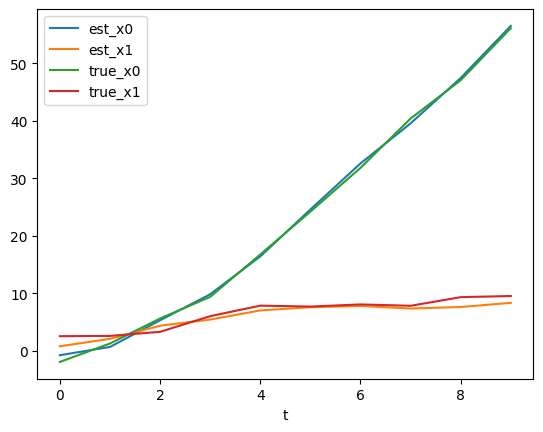

In [173]:
import matplotlib.pyplot as plt

plt.plot(x_est, label=["est_x0", "est_x1"])
plt.plot(x, label=["true_x0", "true_x1"])
plt.legend()
plt.xlabel("t")